<a href="https://colab.research.google.com/github/MarinaComotti/Finance_Specialist_AI/blob/main/Finance_Specialist_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Finance Specialist AI**

In this project, the fine-tuning of Meta's Llama 3 model will be carried out to develop a Large Language Model (LLM) specialist in answering questions related to the financial sector. The project will cover everything from downloading the dataset, cleaning and preprocessing data, to training the model and its subsequent evaluation.

## **Import libraries  and setup development environment**




The first step will be import all the libraries and tools that are going to be used in each of the stages.

A brief description of some of them is found below:



*   🤗 **Transformers**: An open-source library that provides APIs and tools for downloading and training state-of-the-art pretrained models. It also supports framework interoperability between PyTorch, TensorFlow, and JAX.
*   🤗 **Datasets**: A library that provides a unified way to load and process different types of datasets for audio, computer vision, and natural language processing (NLP) tasks.
*   🤗 **Accelerate:** A library that simplifies the process of training machine learning models on different hardware accelerators, such as GPUs and TPUs, by providing a consistent interface and handling the low-level details of distributed training and optimization.
*   🤗 **Evaluate:** This library provides a streamlined way to evaluate and analyze the performance of machine learning models. It offers a wide range of pre-built metrics and evaluation tool.
*   **bitsandbytes:** A lightweight Python wrapper around CUDA custom functions, particularly 8-bit optimizers, matrix multiplication (LLM.int8()), and 8 + 4-bit quantization functions.
*   **TRL - Transformer Reinforcement Learning:** A full stack library to fine-tune and align transformer language and diffusion models using methods such as Supervised Fine-tuning (SFT). It is built on top of the 🤗 transformers library is integrated with it.
*  **🤗 PEFT (Parameter-Efficient Fine-Tuning):** A library for efficiently adapting large pretrained models to various downstream applications without fine-tuning all of a model’s parameters, which can be prohibitively costly.
*  **Flash Attention:** An IO-aware exact attention algorithm that uses tiling to reduce the number of memory reads/writes between GPU high bandwidth memory (HBM) and GPU on-chip SRAM, enabling faster training of Transformers.
* **Weights & Biases:** A machine learning platform that provides a comprehensive dashboard to visualize metrics, compare runs, evaluate model performance, among others features to track and visualize machine learning experiments and manage and version models.


In [ ]:
# Install Pytorch
!pip install "torch==2.2.1" tensorboard

# Install Hugging Face libraries
!pip install  --upgrade \
  "transformers==4.36.2" \
  "datasets==2.16.1" \
  "accelerate==0.26.1" \
  "evaluate==0.4.1" \
  "bitsandbytes==0.42.0" \

# install peft & trl from github
!pip install git+https://github.com/huggingface/trl@a3c5b7178ac4f65569975efadc97db2f3749c65e --upgrade
!pip install git+https://github.com/huggingface/peft@4a1559582281fc3c9283892caea8ccef1d6f5a4f --upgrade

# Weights & Biases
!pip install wandb -qU


  Using cached transformers-4.36.2-py3-none-any.whl.metadata (126 kB)
  Using cached datasets-2.16.1-py3-none-any.whl.metadata (20 kB)
  Using cached accelerate-0.26.1-py3-none-any.whl.metadata (18 kB)
  Using cached evaluate-0.4.1-py3-none-any.whl.metadata (9.4 kB)
  Using cached bitsandbytes-0.42.0-py3-none-any.whl.metadata (9.9 kB)
  Using cached tokenizers-0.15.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached dill-0.3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached fsspec-2023.10.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached responses-0.18.0-py3-none-any.whl.metadata (29 kB)
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
  Using cached multiprocess-0.70.15-py310-none-any.whl.metadata (7.2 kB)
Using cached transformers-4.36.2-py3-none-any.whl (8.2 MB)
Using cached datasets-2.16.1-py3-none-any.whl (507 kB)
Using cached accelerate

In [ ]:
import torch; assert torch.cuda.get_device_capability()[0] >= 8, 'Hardware not supported for Flash Attention'
# install flash-attn
!pip install ninja packaging
!MAX_JOBS=4 pip install flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 38.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.4 MB/s eta 0:00:00
  Created wheel for flash-attn: filename=flash_attn-2.5.9.post1-cp310-cp310-linux_x86_64.whl size=120821333 sha256=7bfd5ecaaf20577cd1255eaa90d9008a09050b3408ba6388bcbc5b6144f482d0
  Stored in directory: /root/.cache/pip/wheels/cc/ad/f6/7ccf0238790d6346e9fe622923a76ec218e890d356b9a2754a
Successfully built flash-attn


In [ ]:
# HuggingFace account
from huggingface_hub import notebook_login

# Data Adquisition and Exploratory Data Analysis
from datasets import load_dataset, Dataset
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import string
import random

# Data preprocessing and fine-tuning
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from trl import setup_chat_format
from peft import LoraConfig
from transformers import TrainingArguments
from trl import SFTTrainer
from peft import PeftModel, PeftConfig
from transformers import pipeline
import textwrap

# Experiment Tracking
import wandb

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [ ]:
%env WANDB_PROJECT=llama3_8B_finance_qa
%env WANDB_WATCH=all


# Log in to the Hugging Face and Weights & Biases accounts

notebook_login()
wandb.login()

env: WANDB_PROJECT=llama3_8B_finance_qa
env: WANDB_WATCH=all


## **Data Acquisition**

For model training, the **Sujet-Finance-Instruct-177k** dataset will be used, which will be downloaded from the Hugging Face Hub. This dataset was built from the combination of 18 distinct datasets hosted on Hugging Face and its goal is to be used in fine-tuning LLMs on seven different tasks related to the financial sector.





In [ ]:
# Load the dataset
raw_dataset = load_dataset("sujet-ai/Sujet-Finance-Instruct-177k", split="train")
print('\nDataset information: \n')
raw_dataset

Generating train split: 0 examples [00:00, ? examples/s]


Dataset information: 



Dataset({
    features: ['Unnamed: 0', 'inputs', 'answer', 'system_prompt', 'user_prompt', 'task_type', 'dataset', 'index_level', 'conversation_id'],
    num_rows: 177597
})

## **Exploratory Data Analysis**

**Dataset tasks:**

In [ ]:
task_types = {task_name for task_name in raw_dataset['task_type']}

print('Tasks for which the dataset was created: \nNER sentiment analysis, question/answer, question/answer with conversation, question/answer with context, sentiment analysis, topic clasiffication and yes/no question: \n')

task_types

Tasks for which the dataset was created: 
NER sentiment analysis, question/answer, question/answer with conversation, question/answer with context, sentiment analysis, topic clasiffication and yes/no question: 



{'ner_sentiment_analysis',
 'qa',
 'qa_conversation',
 'qa_with_context',
 'sentiment_analysis',
 'topic_classification',
 'yes_no_question'}

The data will be split into subsets according to the corresponding task:

In [ ]:
ner_sa_dataset = raw_dataset.filter(lambda x: 'ner_sentiment_analysis' in x["task_type"])
qa_conversation_dataset = raw_dataset.filter(lambda x: 'qa_conversation' in x["task_type"])
no_qa_conv_context_dataset = raw_dataset.filter(lambda x: 'qa_conversation' not in x["task_type"] and 'qa_with_context' not in x["task_type"] )
qa_dataset = no_qa_conv_context_dataset.filter(lambda x: 'qa' in x["task_type"])
qa_with_context_dataset = raw_dataset.filter(lambda x: 'qa_with_context' in x["task_type"])
sa_dataset = raw_dataset.filter(lambda x: 'sentiment_analysis' in x["task_type"])
topic_dataset = raw_dataset.filter(lambda x: 'topic_classification' in x["task_type"])
yes_no_dataset = raw_dataset.filter(lambda x: 'yes_no_question' in x["task_type"])

Filter:   0%|          | 0/177597 [00:00<?, ? examples/s]

Filter:   0%|          | 0/177597 [00:00<?, ? examples/s]

Filter:   0%|          | 0/177597 [00:00<?, ? examples/s]

Filter:   0%|          | 0/121509 [00:00<?, ? examples/s]

Filter:   0%|          | 0/177597 [00:00<?, ? examples/s]

Filter:   0%|          | 0/177597 [00:00<?, ? examples/s]

Filter:   0%|          | 0/177597 [00:00<?, ? examples/s]

Filter:   0%|          | 0/177597 [00:00<?, ? examples/s]

To train the model to answer finance-related questions, only the subset belonging to the 'question/answer' task will be used:

In [ ]:
print('Number of rows of question/answer set: ', qa_dataset.num_rows)
print('Features info: ', qa_dataset.features)

Number of rows of question/answer set:  38801
Features info:  {'Unnamed: 0': Value(dtype='int64', id=None), 'inputs': Value(dtype='string', id=None), 'answer': Value(dtype='string', id=None), 'system_prompt': Value(dtype='string', id=None), 'user_prompt': Value(dtype='string', id=None), 'task_type': Value(dtype='string', id=None), 'dataset': Value(dtype='string', id=None), 'index_level': Value(dtype='float64', id=None), 'conversation_id': Value(dtype='float64', id=None)}


To explore the data, a random sample will be taken:

In [ ]:
qa_sample = qa_dataset.shuffle(seed=42).select(range(3880))

**The "Unnamed: 0" column:**

When exploring this column, it is found that it appears to be an ID




In [ ]:
print(qa_sample[:20]['Unnamed: 0'])
print("Number of values in the 'Unnamed: 0' row: ", len(qa_dataset['Unnamed: 0']))
print("Number of unique values in the 'Unnamed: 0' row: ", len(qa_dataset.unique("Unnamed: 0")))

[149695, 144799, 148312, 121602, 123341, 135284, 134152, 136430, 130333, 136274, 89591, 144687, 103728, 102314, 136158, 129276, 91239, 124437, 131139, 100514]
Number of values in the 'Unnamed: 0' row:  38801


Flattening the indices:   0%|          | 0/38801 [00:00<?, ? examples/s]

Number of unique values in the 'Unnamed: 0' row:  38801


To improve interpretability, the column 'Unnamed: 0' will be renamed to 'id':

In [ ]:
qa_dataset = qa_dataset.rename_column(
    original_column_name="Unnamed: 0", new_column_name="id"
)
qa_sample = qa_dataset.shuffle(seed=42).select(range(3880))
qa_dataset

Dataset({
    features: ['id', 'inputs', 'answer', 'system_prompt', 'user_prompt', 'task_type', 'dataset', 'index_level', 'conversation_id'],
    num_rows: 38801
})

**The "inputs" column**:

In [ ]:
print("An example of the 'input' column:\n ")
qa_sample[0]['inputs']

An example of the 'input' column:
 


'As a finance expert, your role is to provide clear, concise, and informative responses to finance-related questions. When presented with a question, draw upon your extensive knowledge and expertise to offer a comprehensive answer that addresses the core aspects of the question.\n\nQuestion:\nGenerate a set of rules to follow in order to perform better at work.\n\nAnswer:'

The 'input' column contains both uppercase and lowercase letters. This column, along with all other columns with string values, will be formatted to contain only lowercase letters:





In [ ]:
def lowercase_condition(data):
    return {"inputs": data["inputs"].lower(),
            "answer": data["answer"].lower(),
            "system_prompt": data["system_prompt"].lower(),
            "user_prompt": data["user_prompt"].lower(),
            "dataset": data["dataset"].lower()
            }

qa_dataset = qa_dataset.map(lowercase_condition)
qa_sample = qa_dataset.shuffle(seed=42).select(range(3800))

qa_sample[0]

Map:   0%|          | 0/38801 [00:00<?, ? examples/s]

{'id': 149695,
 'inputs': 'as a finance expert, your role is to provide clear, concise, and informative responses to finance-related questions. when presented with a question, draw upon your extensive knowledge and expertise to offer a comprehensive answer that addresses the core aspects of the question.\n\nquestion:\ngenerate a set of rules to follow in order to perform better at work.\n\nanswer:',
 'answer': "1. set clear, achievable goals and prioritize them.\n2. minimize distractions and focus on the tasks at hand. \n3. stay organized and track your progress and goals.\n4. network and build relationships with your colleagues. \n5. take regular breaks and or go for a walk to refresh your mind.\n6. take constructive criticism and use it to grow.\n7. be proactive and stay ahead of deadlines.\n8. celebrate small successes and don't be afraid to learn from your mistakes.",
 'system_prompt': 'as a finance expert, your role is to provide clear, concise, and informative responses to financ

**The "index_level" and "conversation_id" columns:**


In [ ]:
qa_index_none = qa_dataset.filter(lambda x: x["index_level"] is not None)
qa_conv_none = qa_dataset.filter(lambda x: x["conversation_id"] is not None)
print("Number of rows of 'index_level' column that contain different values than None: ", qa_index_none.num_rows)
print("Some examples of 'index_level' column:\n", qa_sample['index_level'][:20])
print('\n')
print("Number of rows of 'conversation_id' column that contain different values than None: ", qa_conv_none.num_rows)
print("Some examples of 'conversation_id' column:\n", qa_sample['index_level'][:20])

Filter:   0%|          | 0/38801 [00:00<?, ? examples/s]

Filter:   0%|          | 0/38801 [00:00<?, ? examples/s]

Number of rows of 'index_level' column that contain different values than None:  0
Some examples of 'index_level' column:
 [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


Number of rows of 'conversation_id' column that contain different values than None:  0
Some examples of 'conversation_id' column:
 [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


When exploring this features, it's observed that they only have None values in all entries. This is because these features only have important values for other tasks in the dataset. To train the model, these columns won't be used, so they will be eliminated later.

**The "system_prompt" column:**

Now, let's check whether all entries include this system prompt:

"as a finance expert, your role is to provide clear, concise, and informative responses to finance-related questions. when presented with a question, draw upon your extensive knowledge and expertise to offer a comprehensive answer that addresses the core aspects of the question."

In [ ]:
SYSTEM_PROMPT = qa_sample[0]['system_prompt']
qa_other_system_prompt = qa_dataset.filter(lambda x: SYSTEM_PROMPT not in x['system_prompt'])

print("Number of entries that have another system prompt: ", qa_other_system_prompt.num_rows)
qa_other_system_prompt[:4]['system_prompt']

Filter:   0%|          | 0/38801 [00:00<?, ? examples/s]

Number of entries that have another system prompt:  44


['as a knowledgeable financial analyst, your task is to provide accurate and relevant answers to questions related to finance. use your expertise in finance to formulate a concise response that directly addresses the question.',
 'as a knowledgeable financial analyst, your task is to provide accurate and relevant answers to questions related to finance. use your expertise in finance to formulate a concise response that directly addresses the question.',
 'as a knowledgeable financial analyst, your task is to provide accurate and relevant answers to questions related to finance. use your expertise in finance to formulate a concise response that directly addresses the question.',
 'as a knowledgeable financial analyst, your task is to provide accurate and relevant answers to questions related to finance. use your expertise in finance to formulate a concise response that directly addresses the question.']

To ensure that all entries have the same system_prompt, the value of this column will be changed in those rows that have a different system_prompt:

In [ ]:
def change_system_prompt(entry):
  if entry['system_prompt'] != SYSTEM_PROMPT:
    entry['system_prompt'] = SYSTEM_PROMPT
  return entry

qa_dataset = qa_dataset.map(change_system_prompt)
qa_sample = qa_dataset.shuffle(seed=42).select(range(3800))

Map:   0%|          | 0/38801 [00:00<?, ? examples/s]

Again, let's check that no entries have a different system_prompt to ensure that the changes were added correctly:

In [ ]:
qa_other_system_prompt = qa_dataset.filter(lambda x: SYSTEM_PROMPT not in x['system_prompt'])

print("Number of entries that have another system prompt: ", qa_other_system_prompt.num_rows)

Filter:   0%|          | 0/38801 [00:00<?, ? examples/s]

Number of entries that have another system prompt:  0


**The "user_prompt" column:**

In this feature, it can be observed that all the user queries have an indication of 'question:' before them:

In [ ]:
qa_sample['user_prompt'][:5]

['question:\ngenerate a set of rules to follow in order to perform better at work.',
 'question:\ndrill a hole in the wall.',
 'question:\ngenerate a python script to calculate the sum of all array elements.',
 'question:\nmake a recommendation for a family movie',
 'question:\npropose a solution for reducing global warming.']

The values in the 'user_prompt' column will be modified to remove the 'question:' prefix, leaving only the user queries:

In [ ]:
def remove_question_word(entry, word, column):
  """It removes a specific word from a column of an entry."""
  start = entry[column].find(word)
  entry[column] = entry[column][start + len(word):]
  return entry


qa_dataset = qa_dataset.map(lambda x: remove_question_word(x, "question:\n", 'user_prompt'))
qa_sample = qa_dataset.shuffle(seed=42).select(range(3800))
qa_sample['user_prompt'][:5]

Map:   0%|          | 0/38801 [00:00<?, ? examples/s]

['generate a set of rules to follow in order to perform better at work.',
 'drill a hole in the wall.',
 'generate a python script to calculate the sum of all array elements.',
 'make a recommendation for a family movie',
 'propose a solution for reducing global warming.']

**Wordclouds:**

Finally, to observe the most frequent words in the questions and answers, two wordclouds will be created for each:

In [ ]:
avoid_characters = {"*","!","$","%","^","&","#","@","+","-","_","=","/","|","\/",":",";",",",".","?","<",">","(",")","[","]","{","}", "'", '"',"`", "?",
                   "0","1", "2", "3", "4", "5", "6", "7", "8", "9", "ll"}
def get_question_words(data):
  '''Function that returns a string with the concatenation of all the unique words from the user questions in the dataset.'''
  words_set = set()

  for text in data['user_prompt']:
    for word in text.split():
      for char in avoid_characters:
        word = word.replace(char, "")
      words_set.add(word)

  question_words = " ".join(words_set)


  return question_words


question_words = get_question_words(qa_sample)
question_words

' a pronunciation encountered ses keyboard gains german pb country political reword system prism teenagers businesses arbitrage curve r banking dungeons is australia conversational least inspire paraelogram evening discusses needs enfants deal grocery reinvested royalties background circuit plays rewrite idiom marbury merger debt melody breathing options prime stranger shades est cashed quadratic spots tomatoes marks bookorganizer writings behavior classified analyse trustable machine relevant recycling details add charity taxation passwords limerick from predict meant ebook analysing style difficulty happily lotus phrases rhythm skin exposure response repairs acf started retired decline mean theaters interviewing oceanic whose leap selfdefense ki tea person uprising large implements australian calculation declaration reputable handkerchief progress ii knight movies assurance cosigner parsimony extra leakage students broadway contribution fscss boat post certain roots phonebased iiquid

In [ ]:
def get_answer_words(data):
  '''Function that returns a string with the concatenation of all the unique words from the assistant answers in the dataset.'''
  words_set = set()
  for text in qa_sample['answer']:
    for word in text.split():
      for char in avoid_characters:
        word = word.replace(char, "")
      words_set.add(word)

  answer_words = " ".join(words_set)
  return answer_words

answer_words = get_answer_words(qa_sample)
answer_words

' foodstuffs a grape kassenzettel pronunciation encountered reforms ecstatic ses scented tanzania loose sharply keyboard gains viable crossover german loud matters peacefuy parttime pb crumbled arcc country political unconditional irregularly burglar sip system mildly canadas hosed lifts electoral competence prism teenagers ivory intense arbitrage businesses curve r cutters struck biotech banking globe httpwwwinvestopediacomuniversityintrotoordertypesconditionalordersasp courteous habitability alerting yri cosi responds marino is macbooks unable dismissive establishment australia conversational least screams exploit inspire disabilities seldom oxygen lstcountelement paraelogram poles enacted evening discusses needs perfection pharmaceutical anonymous nepal databases ringing deal durable crack curated encounters humanprovided grocery disrupt rooms unhealthful background circuit royalties reinvested plays inject rewrite idiom resort combine interestso marbury ibm merger drizzle reflectin

In [ ]:
#Words and letters that should not be included in the word clouds
other_stopwords = {'question:'}
for letter in string.ascii_lowercase:
  other_stopwords.add(letter)
STOPWORDS.update(other_stopwords)


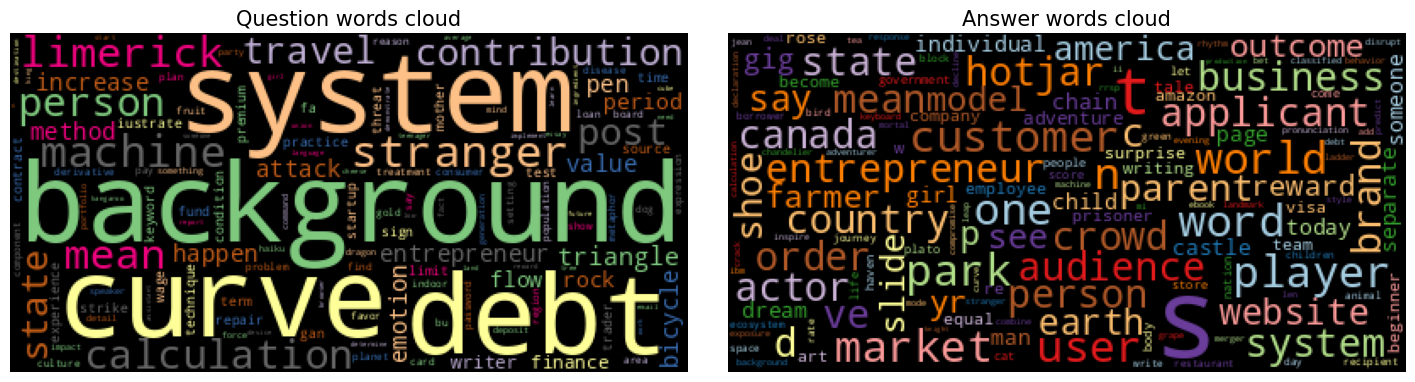

In [ ]:
def plot_cloud(wordcloudQ, wordcloudA):
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 12))
  # Question words cloud:
  axs[0].imshow(wordcloudQ)
  axs[0].set_title("Question words cloud", fontsize=15)
  axs[0].axis("off");
  # Answer words cloud:
  axs[1].imshow(wordcloudA)
  axs[1].set_title("Answer words cloud", fontsize=15)
  axs[1].axis("off");

  plt.subplots_adjust(wspace=0.06)


 # Generate wordclouds
wordcloudQ = WordCloud(random_state=1,
                      background_color='black',
                      colormap='Accent',
                      collocations=False,
                      stopwords = STOPWORDS,
                      max_font_size=65).generate(question_words)

wordcloudA = WordCloud(random_state=1,
                      background_color='black',
                      colormap='Paired',
                      collocations=False,
                      stopwords = STOPWORDS,
                      max_font_size=65).generate(answer_words)

 # Plot wordclouds
plot_cloud(wordcloudQ, wordcloudA)

The word clouds created display the most frequent words included in the questions and answers of the dataset. It can be observed that most of the words are related to the field of Finance.

## **Data Preprocessing**

In this section, the data will be transformed into a conversational format to be able to later apply a chat template.
This format, supported by the Hugging Face library 'trl', will be applied:

```json
{"messages": [{"role": "system", "content": "You are..."}, {"role": "user", "content": "..."}, {"role": "assistant", "content": "..."}]}
{"messages": [{"role": "system", "content": "You are..."}, {"role": "user", "content": "..."}, {"role": "assistant", "content": "..."}]}
{"messages": [{"role": "system", "content": "You are..."}, {"role": "user", "content": "..."}, {"role": "assistant", "content": "..."}]}



In [ ]:
def create_message_format(entry):
  """It applies a conversation format to each entry of the dataset."""
  return {
    "messages": [
      {"role": "system", "content": entry['system_prompt']},
      {"role": "user", "content": entry["user_prompt"]},
      {"role": "assistant", "content": entry["answer"]}
    ]
  }

qa_dataset = qa_dataset.map(create_message_format, remove_columns=qa_sample.features, batched=False)
qa_dataset

Map:   0%|          | 0/38801 [00:00<?, ? examples/s]

Dataset({
    features: ['messages'],
    num_rows: 38801
})

Let's check how the changes turned out by displaying a random sample:

In [ ]:
qa_dataset['messages'][random.randint(1, 38801)]

[{'content': 'as a finance expert, your role is to provide clear, concise, and informative responses to finance-related questions. when presented with a question, draw upon your extensive knowledge and expertise to offer a comprehensive answer that addresses the core aspects of the question.',
  'role': 'system'},
 {'content': 'what is the aproximate population of the uk?', 'role': 'user'},
 {'content': 'the approximate population of the uk is 66.65 million people.',
  'role': 'assistant'}]

Uploading the dataset to the Hugging Face Hub:

In [ ]:
qa_dataset.push_to_hub("question-answer-Subject-Finance-Instruct")

As the last step in the data preprocessing stage, a **chat template** will be applied to the entire dataset. A chat template is part of the tokenizer and specifies how to convert conversations, represented as lists of messages, into a single tokenizable string in the format that the model expects.

In this case, the default chat template of the Llama 3 base model won't be applied because some special tokens, such as <|eot_id|>, <|start_header_id|> or <|end_header_id|> were left untrained. This means that if I would like to use them, I need to train them, which requires more memory.

Instead, I will use a chat template that doesn't require special tokens.

In [ ]:
# Define a chat template that doesn't require special tokens
LLAMA_3_CHAT_TEMPLATE = (
    "{% for message in messages %}"
        "{% if message['role'] == 'system' %}"
            "{{ message['content'] }}"
        "{% elif message['role'] == 'user' %}"
            "{{ '\n\nHuman: ' + message['content'] +  eos_token }}"
        "{% elif message['role'] == 'assistant' %}"
            "{{ '\n\nAssistant: '  + message['content'] +  eos_token  }}"
        "{% endif %}"
    "{% endfor %}"
    "{% if add_generation_prompt %}"
    "{{ '\n\nAssistant: ' }}"
    "{% endif %}"
)

In [ ]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B", use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.chat_template = LLAMA_3_CHAT_TEMPLATE

# Applying the chat template of the tokenizer to the entire dataset
def template_dataset(message):
    return{"text":  tokenizer.apply_chat_template(message["messages"], tokenize=False)}

dataset_chat = qa_dataset.map(template_dataset, remove_columns=["messages"])
print(dataset_chat, "\n")
print("A random example:\n", dataset_chat['text'][random.randint(1, 38801)])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Dataset({
    features: ['text'],
    num_rows: 38801
}) 

A random example:
 as a finance expert, your role is to provide clear, concise, and informative responses to finance-related questions. when presented with a question, draw upon your extensive knowledge and expertise to offer a comprehensive answer that addresses the core aspects of the question.

Human: explain why it is important for organizations to establish organizational goals.<|end_of_text|>

Assistant: organizational goals are essential for providing direction to an organization and its employees. they provide a focus for all activities, helping to create an overarching sense of purpose and drive. goals also help organizations measure and track progress, set priorities, communicate more effectively across the organization, and motivate employees to perform to the best of their abilities.<|end_of_text|>


Now, it will split the dataset into 'train' and 'test' subsets:


*   **Train:** 34920 samples (90%)
*   **Test:** 3881 samples (10%)



In [ ]:
def split_dataset(dataset):
  """Splits the dataset into 'train' and 'test' subsets."""
  data = dataset.train_test_split(test_size=0.1)
  return data['train'], data['test']

train_dataset, test_dataset = split_dataset(dataset_chat)

##**Fine-tuning Llama 3 - 8B**

At this stage, the PEFT method **QLora** will be applied to fine-tune the model. The combination of this **PEFT (Parameter Efficient Fine-Tuning)** method with the **Quantization** technique allows for reducing the number of training parameters and memory usage, achieving comparable performance with a full fine-tuning on a single GPU.

To track and analyze the results obtained, experimental tracking will be carried out with the **Weights and Biases** platform.


*  **QLoRa:**  This method reduces the average memory requirements of fine-tuning using 4-bit quantization to compress a pretrained language model. The model parameters are frozen, and a relatively small number of trainable parameters are added in the form of Low-Rank Adapters (LoRa). During fine-tuning, QLoRA backpropagates gradients through the frozen 4-bit quantized pretrained language model into the Low-Rank Adapters. The LoRA layers are the only parameters being updated during training. ([Dettmers et al., 2023](https://huggingface.co/blog/4bit-transformers-bitsandbytes))

In [ ]:
def set_bnb_config():
  """This function returns a BitsAndBytesConfig object configured for 4-bit quantization"""
  return  BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype= torch.bfloat16,
            bnb_4bit_quant_storage = torch.bfloat16
          )

bnb_config = set_bnb_config()

In [ ]:
def load_model(bnb_config):
  """This function load and return the "meta-llama/Meta-Llama-3-8B" pre-trained model.
      Args:
        bnb_config (BitsAndBytesConfig): The quantization configuration for the model."""

  return AutoModelForCausalLM.from_pretrained(
              "meta-llama/Meta-Llama-3-8B",
              device_map="auto",
              attn_implementation="flash_attention_2",
              torch_dtype=torch.bfloat16,
              quantization_config=bnb_config
            )

model = load_model(bnb_config)

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

In [ ]:
def locaConfig_for_training():
  """This function returns a 'LoraConfig' object configured for model training."""
  return LoraConfig(
              r=16,                         # Lora attention dimension (the “rank”)
              lora_alpha=8,                 # Alpha parameter for Lora scaling
              lora_dropout=0.05,            # Dropout probability for Lora layers
              bias="none",                  # Bias type for LoRA
              target_modules="all-linear",  # The names of the modules to apply the adapter to
              task_type="CAUSAL_LM",
            )

peft_config_1 = locaConfig_for_training()

In [ ]:
def set_args_for_training():
  """This function returns a TrainingArguments object configured for model training. """
  return TrainingArguments(
                output_dir="llama3_8B_finance_qa",
                num_train_epochs=3,
                per_device_train_batch_size=1,
                per_device_eval_batch_size= 1,
                gradient_accumulation_steps=2,
                gradient_checkpointing=True,
                optim="adamw_torch",
                logging_steps=10,
                save_strategy="epoch",
                learning_rate=0.0002,
                bf16=True,
                tf32=True,
                max_grad_norm=0.3,
                warmup_ratio=0.03,
                lr_scheduler_type="constant",
                push_to_hub=True,                       # push model to hub
                evaluation_strategy="epoch",            # evaluate every epoch
                report_to="wandb",                      # report to weights and biases
                run_name="llama3_finance_qa_schmidargs"
            )

args_1 = set_args_for_training()

env: WANDB_PROJECT=llama3_8B_finance_qa
env: WANDB_WATCH=all


In [ ]:
def set_SFTTtrainer(model, args, peft_config):
  """It initializes and configures an instance of SFTTrainer for training the language model.
    Args:
        model: The language model to be trained.
        args: Training arguments (an instance of `TrainingArguments`).
        peft_config: Configuration for Parameter-Efficient Fine-Tuning (PEFT) method."""

  return SFTTrainer(
            model=model,
            args=args,
            train_dataset=train_dataset,
            dataset_text_field="text",
            eval_dataset=test_dataset,
            peft_config=peft_config,
            max_seq_length=512,
            tokenizer=tokenizer,
            packing=True,
            dataset_kwargs={
                "add_special_tokens": False,
                "append_concat_token": False,  # No need to add additional separator token
            },
        )

trainer = set_SFTTtrainer(model, args_1, peft_config_1)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
print("Number of model parameters:\n")
trainer.model.print_trainable_parameters()

trainable params: 41,943,040 || all params: 8,072,204,288 || trainable%: 0.5195983464188562


**Start training:**

In [ ]:
trainer.train()
wandb.finish()

# save model
trainer.save_model()

wandb: Currently logged in as: m-comotti (marina-projects). Use `wandb login --relogin` to force relogin


You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


Epoch,Training Loss,Validation Loss
1,1.151700,1.208765
2,1.098300,1.219920
3,0.915800,1.255621


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


eval/loss,▁▃█
eval/runtime,█▁▅
eval/samples_per_second,▁█▄
eval/steps_per_second,▁█▄
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▆▅▅▆█▅▇▄▃▅▄▅▃▅▂▄▄▄▄▅▄▆▄▄▅▃▆▃▂▃▄▃▄▂▁▄▂▃▃▃
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


At the end of training, we observed that throughout the epochs, the training loss progressively decreased while the validation loss increased in the opposite manner. This is a clear sign of **overfitting**, indicating that the model adapted well to the training data but may have limited capacity to generalize to unseen data. This issue could have arisen due to an excessive number of training epochs.


📈**W&B** validation loss chart: https://api.wandb.ai/links/marina-projects/0k81o41s

















**Merging the LoRA adapter into the base Llama 3 model:** After training the model with QLoRa, only the adapter weights were saved, not the entire model. To simplify text generation inference, the adapter weights will be merged into the model weights and then saved again to the Hugging Face Hub

In [ ]:
def merge_lora_adapter(finetuned_model, base_model, save_name):
  """Merge a LoRA (Low-Rank Adaptation) adapter from a fine-tuned model into a base model.
    Args:
       finetuned_model (str): The name of the fine-tuned model containing the LoRA adapter.
       base_model (str): The name of the base model to merge the LoRA adapter into.
       save_name (str): The name to use for saving and uploading the merged model to the Hugging Face Hub.
  """

  config = PeftConfig.from_pretrained(finetuned_model)
  base_model = AutoModelForCausalLM.from_pretrained(base_model)
  model = PeftModel.from_pretrained(base_model, finetuned_model)

  merged_model = model.merge_and_unload()
  merged_model.save_pretrained(f"./{save_name}",safe_serialization=True, max_shard_size="2GB")
  merged_model.push_to_hub(save_name)

  #The base model tokenizer will be loaded and saved along with the fine-tuned model
  tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=True)
  tokenizer.push_to_hub(save_name)

merge_lora_adapter(finetuned_model="Marina-C/llama3_8B_finance_qa", base_model="meta-llama/Meta-Llama-3-8B", save_name="llama-3-8B-finance-qa")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/83.9M [00:00<?, ?B/s]

## **Run Inference**

Now, let's test the model by making some questions and analyzing the generated answers:



In [ ]:
def config_for_inference():
  """ Configure the text generation pipeline and tokenizer for inference with the fine-tuned model. """

  EOS_TOKEN = "<|end_of_text|>"
  LLAMA_3_CHAT_TEMPLATE = (
    "{% for message in messages %}"
        "{% if message['role'] == 'system' %}"
            "{{ message['content'] }}"
        "{% elif message['role'] == 'user' %}"
            "{{ '\n\nHuman: ' + message['content'] +  eos_token }}"
        "{% elif message['role'] == 'assistant' %}"
            "{{ '\n\nAssistant: '  + message['content'] +  eos_token  }}"
        "{% endif %}"
    "{% endfor %}"
    "{% if add_generation_prompt %}"
    "{{ '\n\nAssistant: ' }}"
    "{% endif %}"
  )
  pipe = pipeline("text-generation", model="Marina-C/llama-3-8B-finance-qa")
  tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B", use_fast=True)
  # Setting up the tokenizer:
  pipe.tokenizer.chat_template = LLAMA_3_CHAT_TEMPLATE
  pipe.tokenizer.pad_token = EOS_TOKEN

  return pipe

pipe = config_for_inference()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/697 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.89G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/2.57G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def question_formatter(question):
  """Formats a given question into a structured message suitable for what the model expects."""

  return [{'content': 'as a finance expert, your role is to provide clear, concise, and informative responses to finance-related questions. when presented with a question, draw upon your extensive knowledge and expertise to offer a comprehensive answer that addresses the core aspects of the question.',
          'role': 'system'},
          {'content': f"{question}",
            'role': 'user'}]


In [ ]:
def generate_answer(pipe, question):
  """This function takes a pipeline and a question, formats the question using the pipeline's
    tokenizer with a chat template, and then generates an answer using the language model with specific
    decoding parameters.

    Returns:
       A tuple containing:
            - outputs: The raw outputs from the language model, which include the generated text along with additional information and metadata.
            - answer (str): The generated answer to the question, extracted and trimmed from the raw outputs."""

  prompt = pipe.tokenizer.apply_chat_template(question, tokenize=False, add_generation_prompt=True)
  outputs = pipe(prompt, max_new_tokens=800,
               do_sample=True,   # the model will take the highest probability token at each step (greedy decoding)
               temperature=0.6,   # controls the randomness of the generated text
               top_k=50,          # the model will only consider the 50 most likely tokens
               top_p=0.9,         # only tokens with a cumulative probability mass of 0.9 or higher will be considered
               eos_token_id=pipe.tokenizer.eos_token_id,
               pad_token_id=pipe.tokenizer.pad_token_id)

  answer = outputs[0]['generated_text'][len(prompt):].strip()

  return outputs, answer

**Question 1:** Explain the role and functions of the World Bank and International Monetary Fund in the global financial system.

In [ ]:
question = "Explain the role and functions of the World Bank and International Monetary Fund in the global financial system"
question_1 = question_formatter(question)
outputs_1, answer_1 = generate_answer(pipe, question_1)

print(f"\nAnswer:\n")
print(textwrap.indent(textwrap.fill(answer_1, width=80), prefix='  '))


Answer:

  the world bank and international monetary fund are two key institutions in the
  global financial system. the world bank provides loans and grants to developing
  countries to help them finance development projects and reduce poverty. it also
  provides technical assistance and policy advice. the international monetary fund
  provides financial support and advice to its member countries to help them
  maintain a stable currency and promote global financial stability. it also
  provides loans to countries in financial distress. both institutions work to
  promote global economic growth and reduce poverty by providing financial and
  technical assistance to developing countries.


**Question 2:** How does the yield on a bond relate to its price?

In [ ]:
question = "How does the yield on a bond relate to its price?"
question_2 = question_formatter(question)
outputs_2, answer_2 = generate_answer(pipe, question_2)

print(f"\nAnswer:\n")
print(textwrap.indent(textwrap.fill(answer_2, width=80), prefix='  '))


Answer:

  1.  the price of a bond is the present value of all future coupon payments and
  the principal repayment. 2.  the yield is the internal rate of return of the
  bond, i.e. the interest rate that makes the present value of all future
  cashflows equal to the price of the bond. 3.  the price of the bond and its
  yield are inversely related: if the price of the bond increases, the yield
  decreases. 4.  the relationship between the price and yield of a bond is
  affected by a variety of factors, including the creditworthiness of the issuer,
  the interest rates offered by other investments, and the supply and demand for
  the bond.


**Question 3:** Explain the difference between a debit card and a credit card.

In [ ]:
question = "Explain the difference between a debit card and a credit card."
question_3 = question_formatter(question)
outputs_3, answer_3 = generate_answer(pipe, question_3)

print(f"\nAnswer:\n")
print(textwrap.indent(textwrap.fill(answer_3, width=80), prefix='  '))


Answer:

  debit cards and credit cards are both types of payment cards that can be used to
  make purchases or withdraw cash from an account. the main difference between
  them is that a debit card is linked to a bank account and the money is deducted
  from the account immediately when a purchase is made, while a credit card is
  linked to a line of credit and the user can make purchases now and pay for them
  later. debit cards typically have lower interest rates than credit cards, but
  credit cards offer more protection against fraud and can be used to build
  credit.


**Question 4:** Explain the concept of short selling and its potential risks.

In [ ]:
question = "Explain the concept of short selling and its potential risks."
question_4 = question_formatter(question)
outputs_4, answer_4 = generate_answer(pipe, question_4)

print(f"\nAnswer:\n")
print(textwrap.indent(textwrap.fill(answer_4, width=80), prefix='  '))


Answer:

  short selling is the practice of selling a security that the seller does not
  own, with the expectation of buying the security back at a lower price. the
  potential risks of short selling include the possibility of unlimited losses, as
  well as the potential for the security to be subject to a short squeeze. a short
  squeeze occurs when there is an increase in demand for the security, causing the
  price to rise and forcing the short sellers to buy the security at a higher
  price than they originally sold it for.


Let's test the model by asking a question in Spanish lenguage:

**Question 5:** ¿Qué son las acciones?

In [ ]:
question = "¿Qué son las acciones?"
question_5 = question_formatter(question)
outputs_5, answer_5 = generate_answer(pipe, question_5)

print(f"\nAnswer in Spanish:\n")
print(textwrap.indent(textwrap.fill(answer_5, width=80), prefix='  '))


Generated Answer:

  una acción es una participación en una empresa. cada acción representa una parte
  de la propiedad de la empresa. las acciones son negociables, lo que significa
  que se pueden comprar y vender en un mercado. las acciones son una forma de
  inversión que puede generar ganancias o pérdidas.


## **Conclusion and Future Work**

Throughout this work, state-of-the-art tools have been applied, and various innovative techniques have been experimented with, resulting in a model specifically trained with financial domain knowledge that yields good results in answering questions and following instructions.

This project will be in continuous change and growth through an iterative process aimed at providing improvements and expanding the model's capabilities. Efforts will be made to enhance each stage, from adding new and better data to the dataset, retraining the model by experimenting with different parameters and hyperparameters, to its subsequent evaluation.

Additionally, efforts will be made to bring this model into production in an environment where it can be used in real life by finance professionals and enthusiasts, so that they can find in it a support and assistance tool for their business and market activities.



## **References**

* Hugging Face Dataset: [*sujet-ai/Sujet-Finance-Instruct-177k*](https://huggingface.co/datasets/sujet-ai/Sujet-Finance-Instruct-177k)
* META Llama 3 model: [*meta-llama/Meta-Llama-3-8B*](https://huggingface.co/meta-llama/Meta-Llama-3-8B)
* META docs: [*Model Cards & Prompt formats: Meta Llama 3*](https://llama.meta.com/docs/model-cards-and-prompt-formats/meta-llama-3)
* Stanford [CS224N: Natural Language Processing with Deep Learning](https://web.stanford.edu/class/cs224n/)
* Schmid, P. (2024): [*Efficiently fine-tune Llama 3 with PyTorch FSDP and Q-Lora*](https://www.philschmid.de/fsdp-qlora-llama3)
* Schmid, P. (2024): [*How to Fine-Tune LLMs in 2024 with Hugging Face*](https://www.philschmid.de/fine-tune-llms-in-2024-with-trl#4-fine-tune-llm-using-trl-and-the-sfttrainer)
* Dettmers et al. (2023): [Making LLMs even more accessible with bitsandbytes, 4-bit quantization and QLoRA](https://huggingface.co/blog/4bit-transformers-bitsandbytes)
* Raschka, S. (2023): [Practical Tips for Finetuning LLMs Using LoRA (Low-Rank Adaptation)](https://magazine.sebastianraschka.com/p/practical-tips-for-finetuning-llms)
* Raschka, S. (2023): [Finetuning LLMs with LoRA and QLoRA: Insights from Hundreds of Experiments](https://lightning.ai/pages/community/lora-insights/#toc12)
* Raschka, S. (2023): [Understanding Large Language Models](https://magazine.sebastianraschka.com/p/understanding-large-language-models)
* Karpathy, A. (2019). [A Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/)
* Vaswani et al. (2017). [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
* Dettmers, T., et al. (2023). [QLoRA: Efficient Finetuning of Quantized LLMs](https://arxiv.org/pdf/2305.14314)
* Hu, E. J., et al. (2021). [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685)






